<a href="https://colab.research.google.com/github/Albertogalred/Data-Science/blob/TFM/NeumoX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**ENTORNO DE GOOGLE Y OBTENCIÓN DE CÓDIGOS DE LOS ARCHIVOS DE DATOS**

In [1]:
!pip install keras

In [2]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
from pydrive.drive import GoogleDrive

drive = GoogleDrive(gauth) # Create GoogleDrive instance with authenticated GoogleAuth instance

# Auto-iterate through all files in the root folder.
file_list = drive.ListFile({'q': "'root' in parents and trashed=false"}).GetList()
for file1 in file_list:
  print('title: %s, id: %s' % (file1['title'], file1['id']))

title: val.zip, id: 1c9VfEbc_WezjvwstMy6D1Zpl5xcmcYH4
title: .ipynb_checkpoints, id: 1-2mIbiWIas_CexviyUBV0SDUNQNRSRT8
title: train.zip, id: 1udaEEc4Zd9Rc-JJE7dyl5KWzpWl_F8Sp
title: NeumoX, id: 1bSyXkNyzwrxPajbY-WNTiCCs4ycwcYnW
title: test.zip, id: 1auHH5qiRaHh4T0bNR_MVe1kOkczY4nmx
title: Colab Notebooks, id: 1Iz8nrdf6kHl5Jimc2xL9zcws8JEA1MUZ


In [4]:
# Download a file based on its file ID.
#

file_id = '1udaEEc4Zd9Rc-JJE7dyl5KWzpWl_F8Sp'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile("train.zip")

file_id = '1auHH5qiRaHh4T0bNR_MVe1kOkczY4nmx'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile("test.zip")

file_id = '1c9VfEbc_WezjvwstMy6D1Zpl5xcmcYH4'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile("val.zip")

**CREACIÓN DE CARPETAS**

In [5]:
!mkdir NeumoX
!cd NeumoX && unzip -q ../train.zip
!cd NeumoX && unzip -q ../test.zip
!cd NeumoX && unzip -q ../val.zip

In [6]:
!pwd

/content


**IMPORTACION**

In [7]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import tensorflow as tf
from tensorflow.random import set_seed
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import binary_accuracy
from tensorflow.keras.layers import Dense,Activation,BatchNormalization,MaxPooling2D,Conv2D,Flatten,Dropout,MaxPool2D,Softmax,Input,ELU
from tensorflow.keras.optimizers import Adam,RMSprop,SGD
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.merge import add
from sklearn.metrics import roc_auc_score,roc_curve,accuracy_score,recall_score,classification_report, confusion_matrix
from tqdm import tqdm  
import cv2   
import scipy
import skimage
from skimage.transform import resize
import matplotlib.pyplot as plt
import h5py
import os, shutil
import glob
import time
import random


**PROCESADO DE IMÁGENES**

In [8]:
import cv2
total_images_train_normal = os.listdir('../content/NeumoX/train/NORMAL/')
total_images_train_pneumonia = os.listdir('../content/NeumoX/train/PNEUMONIA/')

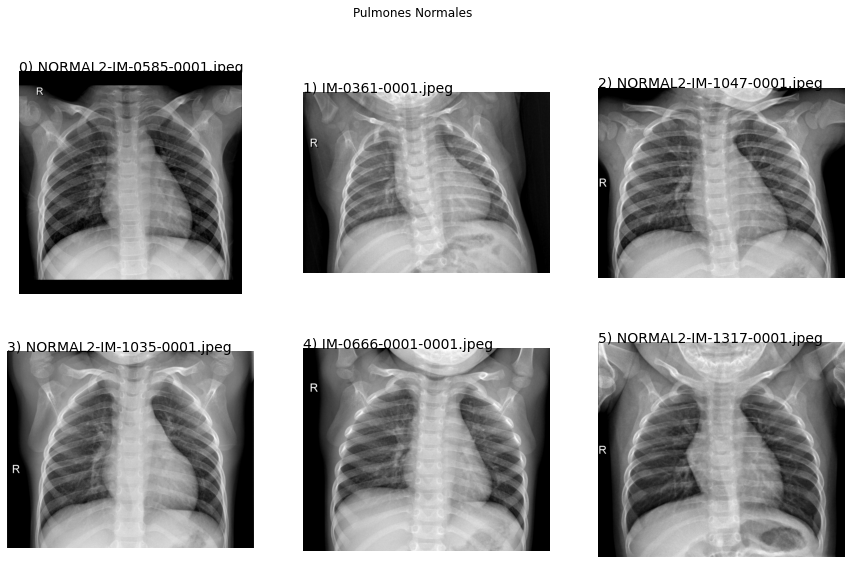

In [9]:
sample_normal = random.sample(total_images_train_normal,6)
f,ax = plt.subplots(2,3,figsize=(15,9))
for i in range(0,6):
    filename=sample_normal[i]
    im = cv2.imread('../content/NeumoX/train/NORMAL/' +sample_normal[i])
    ax[i//3,i%3].imshow(im)
    ax[i//3,i%3].axis('off')
    ax[i//3,i%3].text(0.1, 0.9, str(i)+') ' + filename, fontsize=14)
f.suptitle('Pulmones Normales')
plt.show()

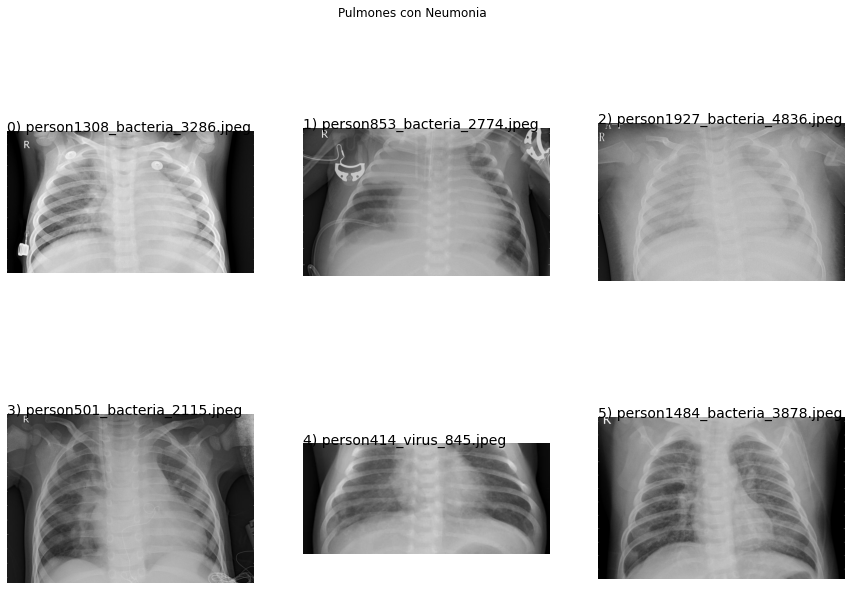

In [10]:
sample_pneumonia = random.sample(total_images_train_pneumonia,6)
f,ax = plt.subplots(2,3,figsize=(15,10))

for i in range(0,6):
    filename=sample_pneumonia[i]
    im = cv2.imread('../content/NeumoX/train/PNEUMONIA/'+sample_pneumonia[i])
    ax[i//3,i%3].imshow(im)
    ax[i//3,i%3].axis('off')
    ax[i//3,i%3].text(0.1, 0.9, str(i)+') ' + filename, fontsize=14)
f.suptitle('Pulmones con Neumonia')
plt.show()

1341
3875


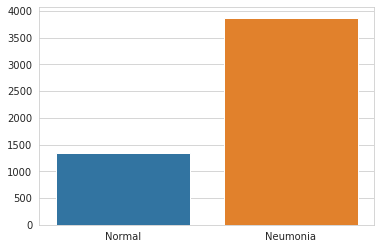

In [11]:
import seaborn as sns
sns.set_style('whitegrid')
sns.barplot(x=['Normal','Neumonia'],y=[len(total_images_train_normal),len(total_images_train_pneumonia)])
print(len(total_images_train_normal))
print(len(total_images_train_pneumonia))

**TAMAÑO DE LAS IMÁGENES**

In [12]:
#os.environ['PYTHONHASHSEED'] = "0"
np.random.seed(1)
set_seed(1)

In [13]:

from tensorflow.keras import backend as K

img_width, img_height = 64, 64

if K.image_data_format() == 'channels_first':
    input_shape = (1, img_width, img_height)
else:
    input_shape = (img_width, img_height, 1)
    
input_shape

(64, 64, 1)

**GENERACIÓN DE LOTES DE IMÁGENES**

In [28]:
TRAIN_DIR = "../content/NeumoX/train/"
TEST_DIR =  "../content/NeumoX/test/"
VALID_DIR=  "../content/NeumoX/val/"

In [29]:
#Generadores Genericos que cojan las imagenes del disco
from keras.preprocessing import image
train_datagen=image.ImageDataGenerator(rescale=1./255.0, shear_range=0.2,zoom_range=0.2, horizontal_flip=True)
validation_datagen=image.ImageDataGenerator(rescale=1./255.0)
test_datagen=image.ImageDataGenerator(rescale=1./255.0)

In [30]:
#Generadores Genericos que cojan las imagenes del disco
from sklearn.metrics import roc_auc_score,roc_curve,accuracy_score,recall_score
from keras.metrics import categorical_accuracy
%matplotlib inline
from keras.preprocessing.image import ImageDataGenerator
gen = ImageDataGenerator()
train_batches = train_datagen.flow_from_directory("../content/NeumoX/train/",model.input_shape[1:3],color_mode="grayscale",shuffle=True,seed=1,
                                        batch_size=16, class_mode='binary')
valid_batches = validation_datagen.flow_from_directory("../content/NeumoX/val/", model.input_shape[1:3],color_mode="grayscale", shuffle=True,seed=1,
                                        batch_size=16, class_mode='binary')
test_batches = test_datagen.flow_from_directory("../content/NeumoX/test/", model.input_shape[1:3], shuffle=False,
                                       color_mode="grayscale", batch_size=16, class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


**MODELO**

In [31]:
model=tf.keras.models.Sequential()

model.add(tf.keras.layers.BatchNormalization(input_shape=input_shape))

model.add(tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='elu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
model.add(tf.keras.layers.Dropout(0.25))


model.add(tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='elu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.BatchNormalization(axis=1))
model.add(tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='elu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.BatchNormalization(input_shape=input_shape))
model.add(tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='elu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128))
model.add(tf.keras.layers.Activation('elu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(256))
model.add(tf.keras.layers.Activation('elu'))
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(2))
model.add(tf.keras.layers.Activation('softmax'))


model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_3 (Batch (None, 64, 64, 1)         4         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 64, 64, 32)        320       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 16, 16, 64)       

In [56]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['sparse_categorical_accuracy'])

In [57]:
history = model.fit(train_batches,validation_data=test_batches,epochs=30, steps_per_epoch=100, validation_steps=20)

Epoch 1/30
100/100 [==============================] - 43s 418ms/step - loss: 0.1560 - sparse_categorical_accuracy: 0.9550 - val_loss: 0.3632 - val_sparse_categorical_accuracy: 0.8750
Epoch 2/30
100/100 [==============================] - 41s 412ms/step - loss: 0.1784 - sparse_categorical_accuracy: 0.9374 - val_loss: 0.2795 - val_sparse_categorical_accuracy: 0.9156
Epoch 3/30
100/100 [==============================] - 42s 416ms/step - loss: 0.1859 - sparse_categorical_accuracy: 0.9322 - val_loss: 0.5192 - val_sparse_categorical_accuracy: 0.8687
Epoch 4/30
100/100 [==============================] - 45s 444ms/step - loss: 0.1651 - sparse_categorical_accuracy: 0.9456 - val_loss: 0.2180 - val_sparse_categorical_accuracy: 0.9344
Epoch 5/30
100/100 [==============================] - 41s 404ms/step - loss: 0.1572 - sparse_categorical_accuracy: 0.9435 - val_loss: 0.4701 - val_sparse_categorical_accuracy: 0.8656
Epoch 6/30
100/100 [==============================] - 41s 409ms/step - loss: 0.1401 -

**PREDECIR EL MODELO CON LOS DATOS DE TEST**

In [58]:
no_steps = len(test_batches)
p = model.predict(test_batches, verbose=True)
pre = pd.DataFrame(p)
pre['item']=pre.reset_index().index
pre["filename"] = test_batches.filenames
pre["label"] = (pre["filename"].str.contains("PNEUMONIA")).apply(int)
pre['pre'] = (pre[1]>0.5).apply(int)
accuracy_score(pre["label"], pre["pre"])

39/39 [==============================] - 7s 174ms/step


0.9134615384615384

**GRÁFICOS**

In [41]:
def plot_metric(history, metric):
    history_dict = history.history
    values = history_dict[metric]
    if 'val_' + metric in history_dict.keys():  
        val_values = history_dict['val_' + metric]

    epochs = range(1, len(values) + 1)

    if 'val_' + metric in history_dict.keys():  
        plt.plot(epochs, val_values, label='Validation')
    plt.semilogy(epochs, values, label='Training')

    if 'val_' + metric in history_dict.keys():  
        plt.title('Training and validation %s' % metric)
    else:
        plt.title('Training %s' % metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid()

    plt.show()


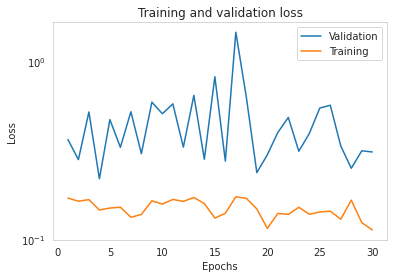

In [59]:
    plot_metric(history,'loss')

In [60]:
pip install plot_metric==0.0.6

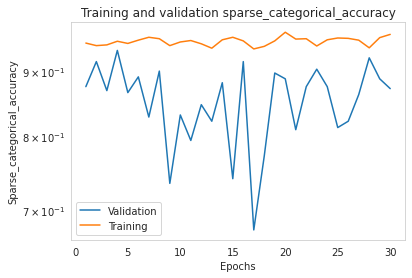

In [61]:

plot_metric(history,'sparse_categorical_accuracy')

**30 primeras predicciones**

In [65]:
pre[:30]

,0,1,item,filename,label,pre
0,9.904930e-01,0.009507,0,NORMAL/IM-0001-0001.jpeg,0,0
1,9.995468e-01,0.000453,1,NORMAL/IM-0003-0001.jpeg,0,0
2,9.175924e-01,0.082408,2,NORMAL/IM-0005-0001.jpeg,0,0
3,9.778637e-01,0.022136,3,NORMAL/IM-0006-0001.jpeg,0,0
4,8.830661e-01,0.116934,4,NORMAL/IM-0007-0001.jpeg,0,0
5,9.944402e-01,0.005560,5,NORMAL/IM-0009-0001.jpeg,0,0
6,9.827633e-01,0.017237,6,NORMAL/IM-0010-0001.jpeg,0,0
7,9.475946e-01,0.052405,7,NORMAL/IM-0011-0001-0001.jpeg,0,0
8,9.296530e-01,0.070347,8,NORMAL/IM-0011-0001-0002.jpeg,0,0
9,9.988810e-01,0.001119,9,NORMAL/IM-0011-0001.jpeg,0,0


**VISUALIZACION PREDICCION ERRONEA**

NORMAL/IM-0022-0001.jpeg


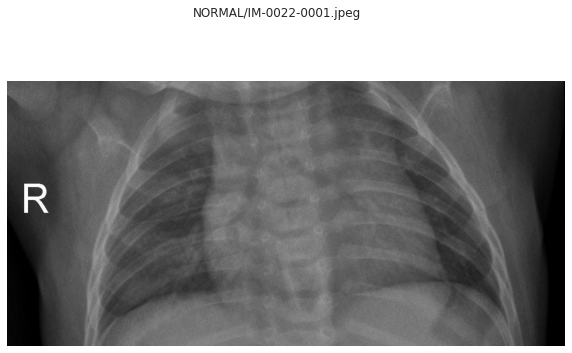

In [70]:
N=16
pre["filename"][N]
print(pre["filename"][N])
import cv2
f,ax = plt.subplots(1,1,figsize=(10,6))
im = cv2.imread('../content/NeumoX/test/'+pre["filename"][N])
ax.imshow(im)
ax.axis('off')
f.suptitle(pre["filename"][N])
plt.show()

**MATRIZ DE PREDICCION**

[[197  37]
 [ 17 373]]


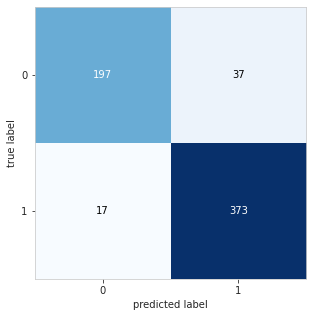

In [71]:
from sklearn.metrics import confusion_matrix
CM = confusion_matrix(pre["label"], pre["pre"])
print(CM)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

**PRECISION Y RECALL**

In [72]:
# Calculate Precision and Recall
tn, fp, fn, tp = CM.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))

Recall of the model is 0.96
Precision of the model is 0.91


In [73]:
accuracy_score(pre["label"], pre["pre"])

0.9134615384615384

**PREDICCIONES ERRONEAS**

In [74]:
wrong=np.where(pre['pre']!=pre['label'])[0]

In [75]:
wrong

array([ 16,  72,  85,  87,  89, 101, 104, 113, 117, 118, 119, 120, 121,
       122, 123, 124, 126, 129, 130, 131, 133, 134, 135, 136, 137, 140,
       141, 142, 143, 144, 146, 160, 186, 193, 200, 220, 226, 282, 287,
       288, 317, 357, 382, 388, 390, 391, 418, 434, 473, 476, 556, 565,
       599, 623])

In [76]:
len(wrong)

54

In [77]:
target_names = ['Normal', 'Pneumonia']
print(classification_report(pre["label"], pre["pre"], target_names=target_names))

              precision    recall  f1-score   support

      Normal       0.92      0.84      0.88       234
   Pneumonia       0.91      0.96      0.93       390

    accuracy                           0.91       624
   macro avg       0.92      0.90      0.91       624
weighted avg       0.91      0.91      0.91       624



In [79]:
# Evaluate the model on test set
score = model.evaluate(test_batches, verbose=0)

# Print test accuracy
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.9134615659713745


**VISUALIZAR AL AZAR LAS PREDICCIONES DEL MODELO**